Assignment 4.1: LSTM Regression Assignment
- Name: Maria Carolina Leal Cardenas
- Date: 02/4/2024

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM , Activation , r2_score
from keras.utils import pad_sequences

In [ ]:
# Importing additional libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [ ]:
df.shape

(2049280, 15)

In [ ]:
# Selecting a random 1% of subset of the data.
df_subset = df.sample(frac=0.01)

# Then, splitting the subset in 80% for training and 20% for validation.
train_df, val_df = train_test_split(df_subset, test_size=0.2)

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [ ]:
# Printing shape values of the training and validation date to verify dimensions.
print(train_df.shape)
print(val_df.shape)

(16394, 16)
(4099, 16)


In [ ]:
train_df.dtypes

index                      int64
Unnamed: 0                 int64
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Datetime                  object
gap_monthly              float64
grp_monthly              float64
v_monthly                float64
gi_monthly               float64
dtype: object

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power'] # Adding predicted value "Global_active_power" to variable: feat_cols

#create list of sequence length GAP readings
seq_arrays = [] # Initiating empty lists for new sequence of arrays.
seq_labs = []   # Initiating empty lists for sequence of labels.

for i in range(seq_length, len(train_df) - ph):  # Iterating for the sequence of length, in this case 30 data points through the entire dataset of the training set.
    seq = train_df[feat_cols].values[i - seq_length:i] # Extracting a sequence of data points from the dataset of the training set.
    seq_arrays.append(seq)                             # Holding all previous extracted data points into the seq_arrays variable.
    label = train_df[feat_cols].values[i + ph]         # Extracting a sequence of indexes from the dataset of the training set.
    seq_labs.append(label)                             # Holding all previous extracted labels to the seq_labs variable.

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [ ]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
- Assertion is used to ensure that certain conditions are met during the execution of the code. In this case, the assertions are used to verify that the shape of the data after being processed matches with the expected shape.
- In other words, it serves as a sanity check to catch potential early issues in the code.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [ ]:
# Normalizign data.
scaler = MinMaxScaler()

# Reshape the 3D array to 2D
seq_arrays_flat = seq_arrays.reshape(-1, seq_arrays.shape[-1])

# Apply the scaler
seq_arrays_normalized_flat = scaler.fit_transform(seq_arrays_flat)

# Reshape back to 3D
seq_arrays_normalized = seq_arrays_normalized_flat.reshape(seq_arrays.shape)


In [ ]:
# Defining path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays_normalized.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,   # Five hidden layers
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,  # Three hidden layers.
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear')) # Final linear layer.
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays_normalized, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

C:\Users\carol\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 30, 5)             │        140 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_34 (Dropout)            │ (None, 30, 5)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_36 (LSTM)                  │ (None, 3)                 │        108 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_35 (Dropout)            │ (None, 3)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │          4 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_17 (Activation)      │ (None, 1)                 │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 4s - 111ms/step - loss: 1.4009 - mse: 1.4009 - val_loss: 1.2384 - val_mse: 1.2384
Epoch 2/100
32/32 - 1s - 17ms/step - loss: 1.1837 - mse: 1.1837 - val_loss: 1.2325 - val_mse: 1.2325
Epoch 3/100
32/32 - 1s - 19ms/step - loss: 1.1746 - mse: 1.1746 - val_loss: 1.2306 - val_mse: 1.2306
Epoch 4/100
32/32 - 1s - 17ms/step - loss: 1.1641 - mse: 1.1641 - val_loss: 1.2289 - val_mse: 1.2289
Epoch 5/100
32/32 - 1s - 20ms/step - loss: 1.1596 - mse: 1.1596 - val_loss: 1.2202 - val_mse: 1.2202
Epoch 6/100
32/32 - 1s - 17ms/step - loss: 1.1527 - mse: 1.1527 - val_loss: 1.2182 - val_mse: 1.2182
Epoch 7/100
32/32 - 1s - 16ms/step - loss: 1.1373 - mse: 1.1373 - val_loss: 1.2199 - val_mse: 1.2199
Epoch 8/100
32/32 - 1s - 17ms/step - loss: 1.1680 - mse: 1.1680 - val_loss: 1.2187 - val_mse: 1.2187
Epoch 9/100
32/32 - 1s - 16ms/step - loss: 1.1319 - mse: 1.1319 - val_loss: 1.2196 - val_mse: 1.2196
Epoch 10/100
32/32 - 1s - 18ms/step - loss: 1.1178 - mse: 1.1178 - val_loss: 1.2195 -

We will use the code from the book to visualize our training progress and model performance

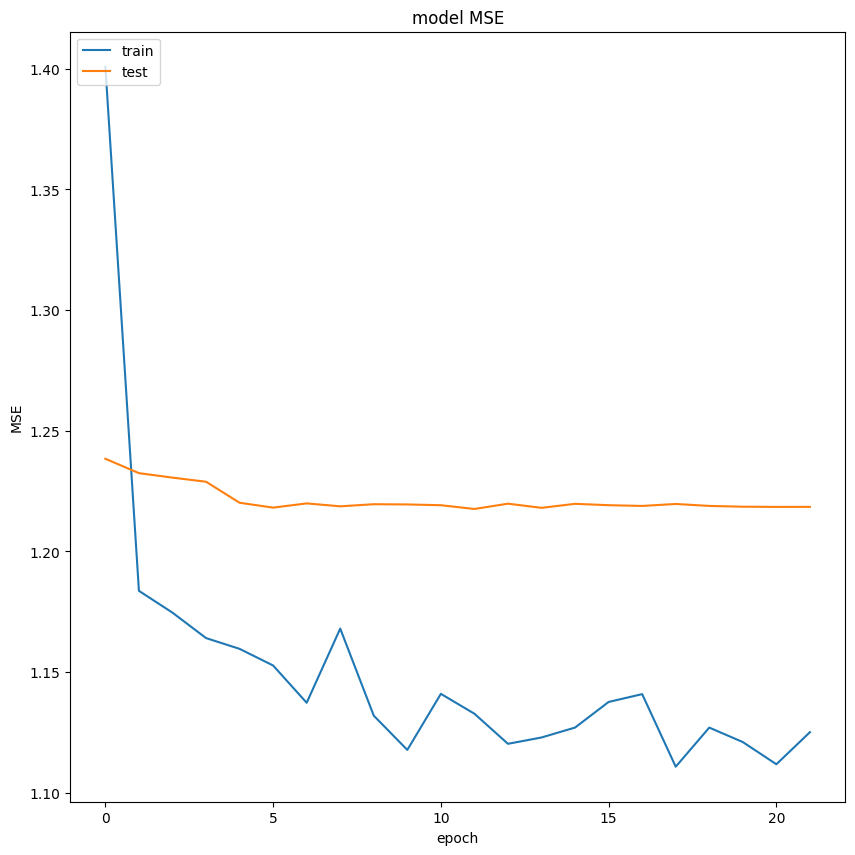

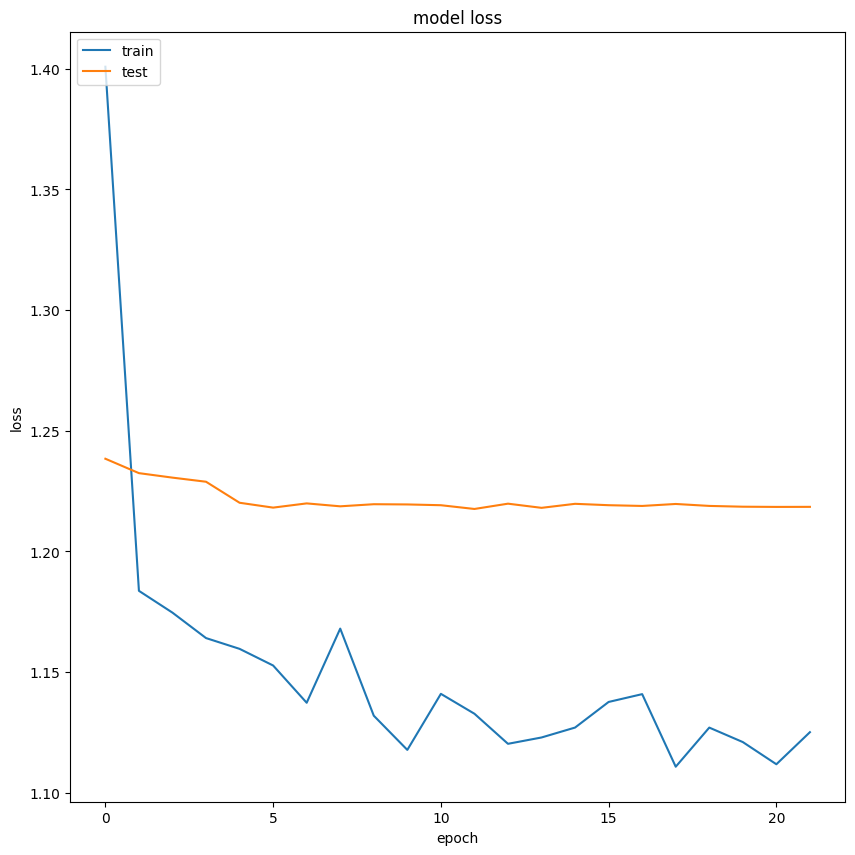

In [ ]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: pad_sequences is commonly used to ensure that sequences in a dataset have the same length. This is particularly important when working with recurrent neural networks or models that require fixed-sized inputs. For this example, we need to initiate predictions after having two Global Active Power (GAP) readings available in sequence. Therefore, we have chosen the option of padding after the final reading by specifying the parameter "post" in the expression.

In [ ]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    # extract the sequence of GAP readings
    seq = val_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    # extract the GAP measurement at the predictive horizon
    lab = val_df[feat_cols].iloc[i+ph-1][0]
    val_arrays.append(seq)
    val_labs.append(lab)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 0s - 3ms/step - loss: 1.1443 - mse: 1.1443

MSE: 1.1443063020706177
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


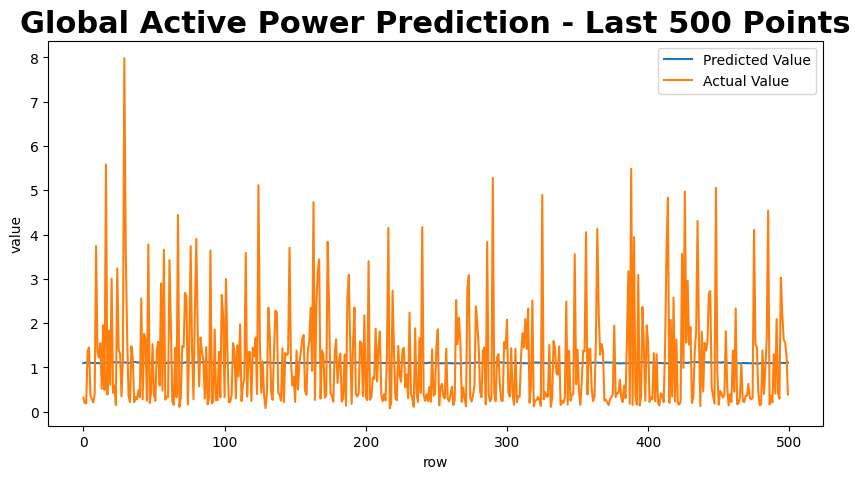

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:

In the Loss Curves graphs, we observed a consistent decrease in validation loss during the training period until reaching epoch 32, where the model ceased to learn. This resulted in a total validation loss metric of 1.21. If the validation loss graph had continued to decrease further in contrast to the training graph, it would have indicated better adaptation of the model.

- Regarding the second graph, the predicted values are not well-appreciated or are excessively influenced by overfitting in the last 500 points. There are several ways to enhance the model:

- Adjusting the activation function at the output layer.
- Incorporating additional hidden layers.
- Modifying parameters for dropout and adjusting the learning rate.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

- From the previous assignment, the linear regression model used to predict 'Global Active Power' with time as the dependent variable did  yield satisfactory results. In this iteration using LSTM, I incorporated the 'unix' time from the previous dataset and included all other variables as predictors. I plotted correlation heatmaps to determine the optimal timeset for predictions. I conducted the experiment both with all variables included and without 'voltage.'

- In the sequential layer, I used 100 units for the first layer, followed by a dropout layer with a rate of 0.1, and concluded with a connected 'dense' layer without an activation function. I retained the 'Adam' optimizer and used the same loss function, 'mean squared error

In [ ]:
# Importing the same csv file in a new dataset called "df2". This time to keep the datime columns.
df2 = pd.read_csv('household_power_clean.csv' , parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

C:\Users\carol\AppData\Local\Temp\ipykernel_21452\950749985.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2 = pd.read_csv('household_power_clean.csv' , parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')


In [ ]:
# Displaying the new dataset and verify that datatime is included.
df2

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
dt,,,,,,,,,,,,,
2006-12-16 17:24:00,0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2006-12-16 17:26:00,2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
2006-12-16 17:27:00,3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
2006-12-16 17:28:00,4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010-11-26 20:58:00,0.971133,0.0348,238.936667,4.080000
2010-11-26 20:59:00,2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010-11-26 20:59:00,0.970667,0.0348,238.975000,4.080000
2010-11-26 21:00:00,2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010-11-26 21:00:00,0.969267,0.0348,238.988000,4.066667


In [ ]:
# Verying the dtypes of the columns . As the next step, we will have to change "Datetime" from object to datatime dtype.
df2.dtypes

Unnamed: 0                 int64
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Datetime                  object
gap_monthly              float64
grp_monthly              float64
v_monthly                float64
gi_monthly               float64
dtype: object

In [ ]:
 # Converting Datetime column into datetime format.
df2['Datetime'] = pd.to_datetime(df2['Datetime'])

In [ ]:
# Verifying datetime dtype.
df2.dtypes

Unnamed: 0                        int64
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Datetime                 datetime64[ns]
gap_monthly                     float64
grp_monthly                     float64
v_monthly                       float64
gi_monthly                      float64
dtype: object

In [ ]:
# Converting "Datetime" to epoch/unix time.
df2['unix']=df2['Datetime'].astype(np.int64)//10**9

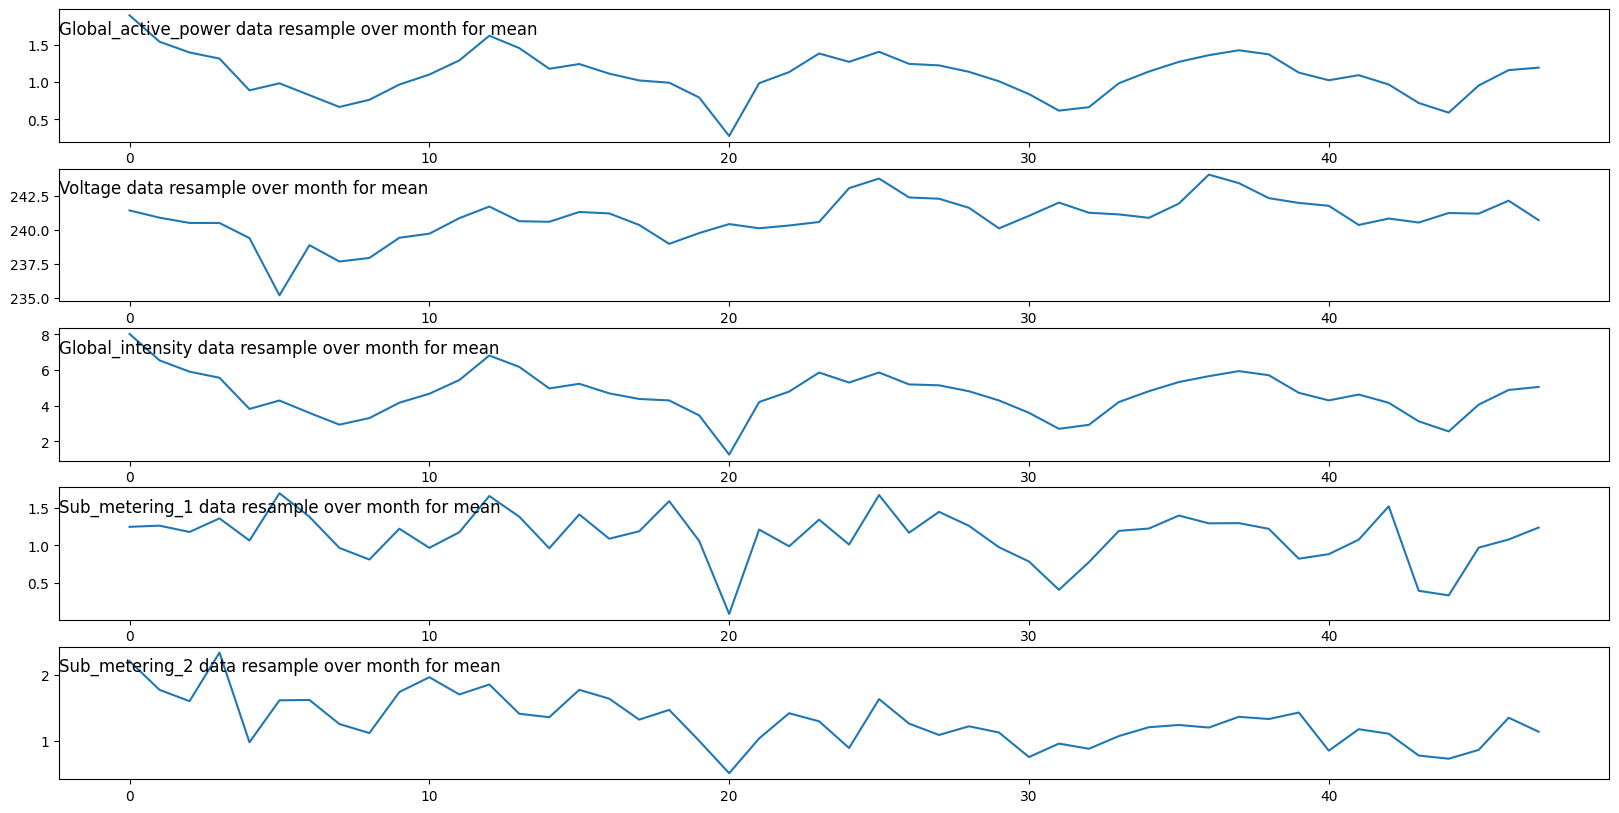

In [ ]:
# Plotting some statiscal analysis to check each input variable flows within month time.
i = 1
cols=[ 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df2.resample('M').mean().values[:, col])
    plt.title(df2.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

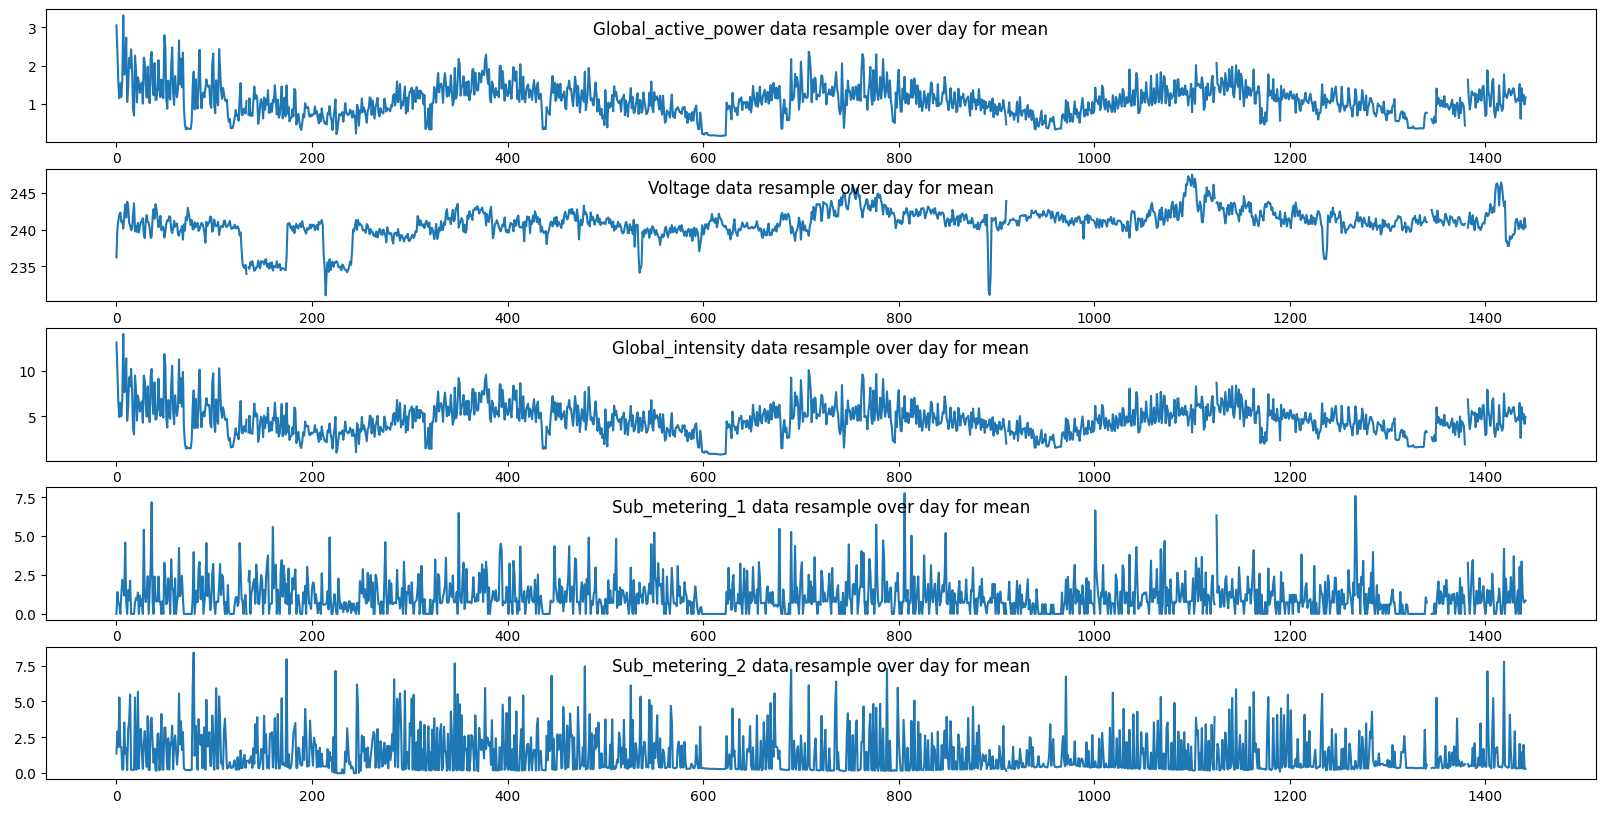

In [ ]:
# Plotting some statiscal analysis to check each input variable flows within day time.
i = 1
cols=[ 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df2.resample('D').mean().values[:, col])
    plt.title(df2.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

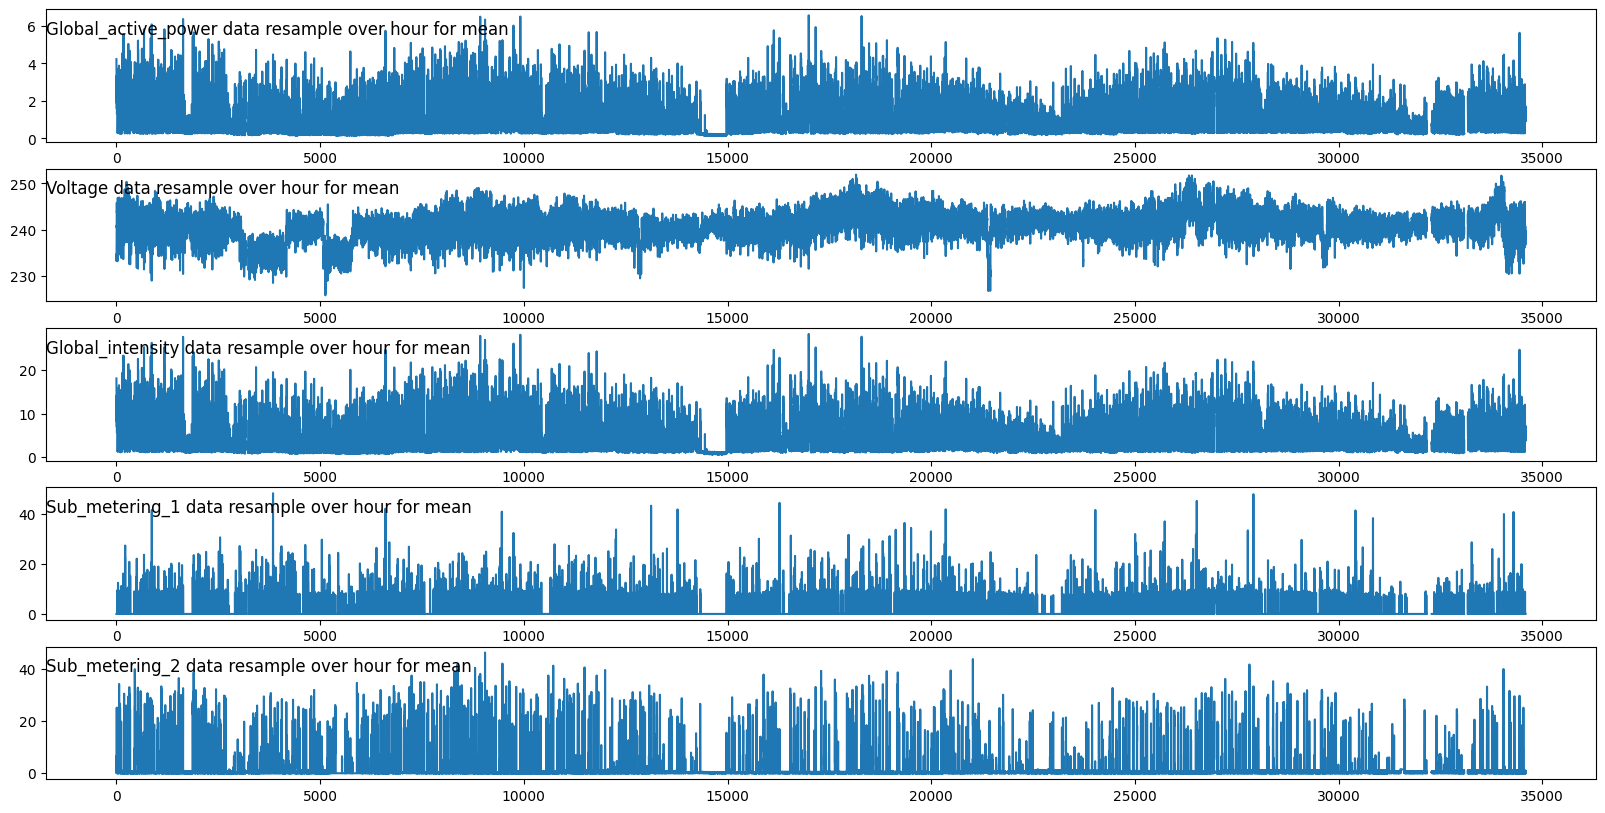

In [ ]:
# Plotting some statiscal analysis to check each input variable flows within hour time.

i = 1
cols=[ 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df2.resample('H').mean().values[:, col])
    plt.title(df2.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

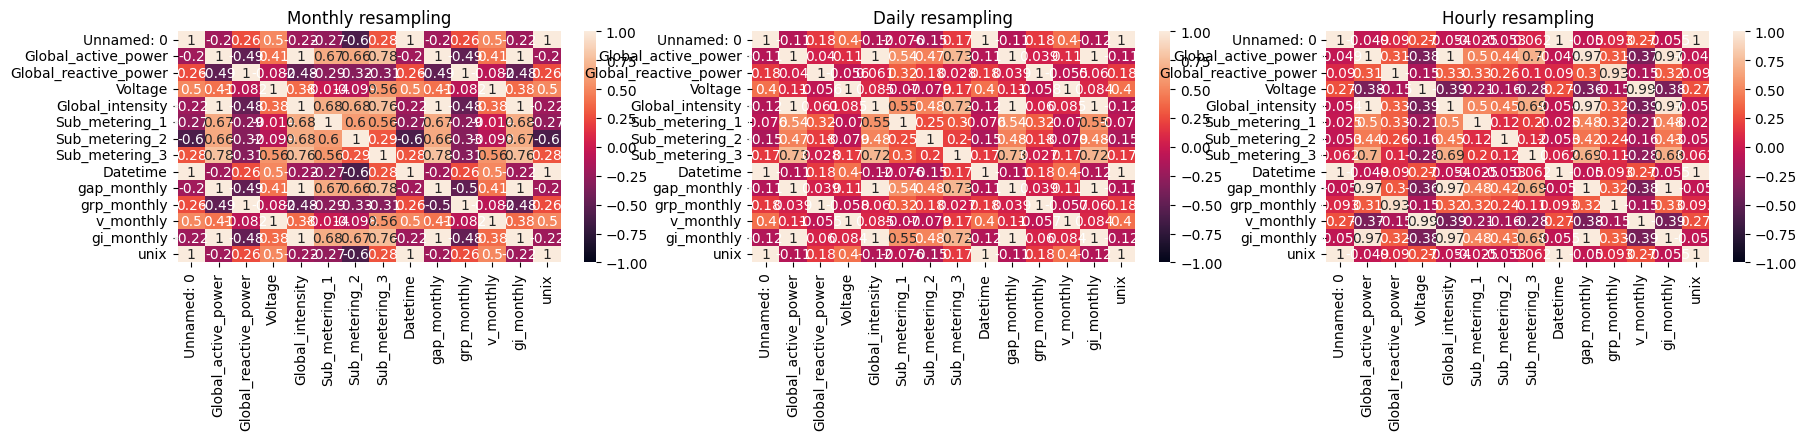

In [ ]:
# Plotting some heatmap for verying correlations between variables.
import seaborn as sns
f= plt.figure(figsize=(21,3))

ax=f.add_subplot(131)
dfm = df2.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax=f.add_subplot(132)
dfd = df2.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)

ax=f.add_subplot(133)
dfh = df2.resample('H').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

In [ ]:
# Including all variables to the feature columns.
df2 = df2[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [ ]:
# Resample dataset only to "hour" time for saving processing time.
df_resample = df2.resample('h').mean()
df_resample.shape

(34589, 7)

In [ ]:
# Splitting the data into: train and validation sets. Selecting  4000 data over 34,589 dat to train, the rest will be used to test the model.


values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/50


C:\Users\carol\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 - 2s - 38ms/step - loss: 0.0232 - val_loss: 0.0105
Epoch 2/50
58/58 - 1s - 10ms/step - loss: 0.0156 - val_loss: 0.0101
Epoch 3/50
58/58 - 0s - 8ms/step - loss: 0.0145 - val_loss: 0.0099
Epoch 4/50
58/58 - 0s - 8ms/step - loss: 0.0139 - val_loss: 0.0097
Epoch 5/50
58/58 - 0s - 8ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 6/50
58/58 - 1s - 9ms/step - loss: 0.0131 - val_loss: 0.0094
Epoch 7/50
58/58 - 0s - 8ms/step - loss: 0.0127 - val_loss: 0.0094
Epoch 8/50
58/58 - 0s - 8ms/step - loss: 0.0125 - val_loss: 0.0093
Epoch 9/50
58/58 - 0s - 8ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 10/50
58/58 - 0s - 8ms/step - loss: 0.0123 - val_loss: 0.0093
Epoch 11/50
58/58 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0093
Epoch 12/50
58/58 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0093
Epoch 13/50
58/58 - 0s - 9ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 14/50
58/58 - 1s - 9ms/step - loss: 0.0122 - val_loss: 0.0092
Epoch 15/50
58/58 - 0s - 8ms/step - loss: 0.0123 - val_loss: 0.009

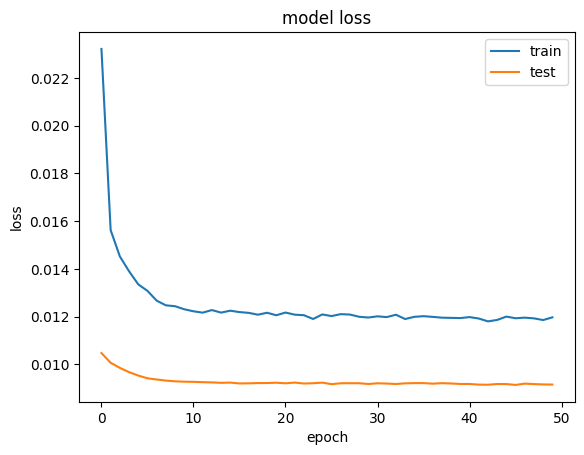

943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test RMSE: 0.616


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2]))) # Adding 100 units to the fist layer.
model.add(Dropout(0.1)) # Chaging the "Dropout" parameter to 0.1 instead of 0.2
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') # I kept the same loss function and optimizer.

# Fitting model.
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False) # Reducing less epochs to 50 and batchsize to 70.

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# Inverting scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Inverting  scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

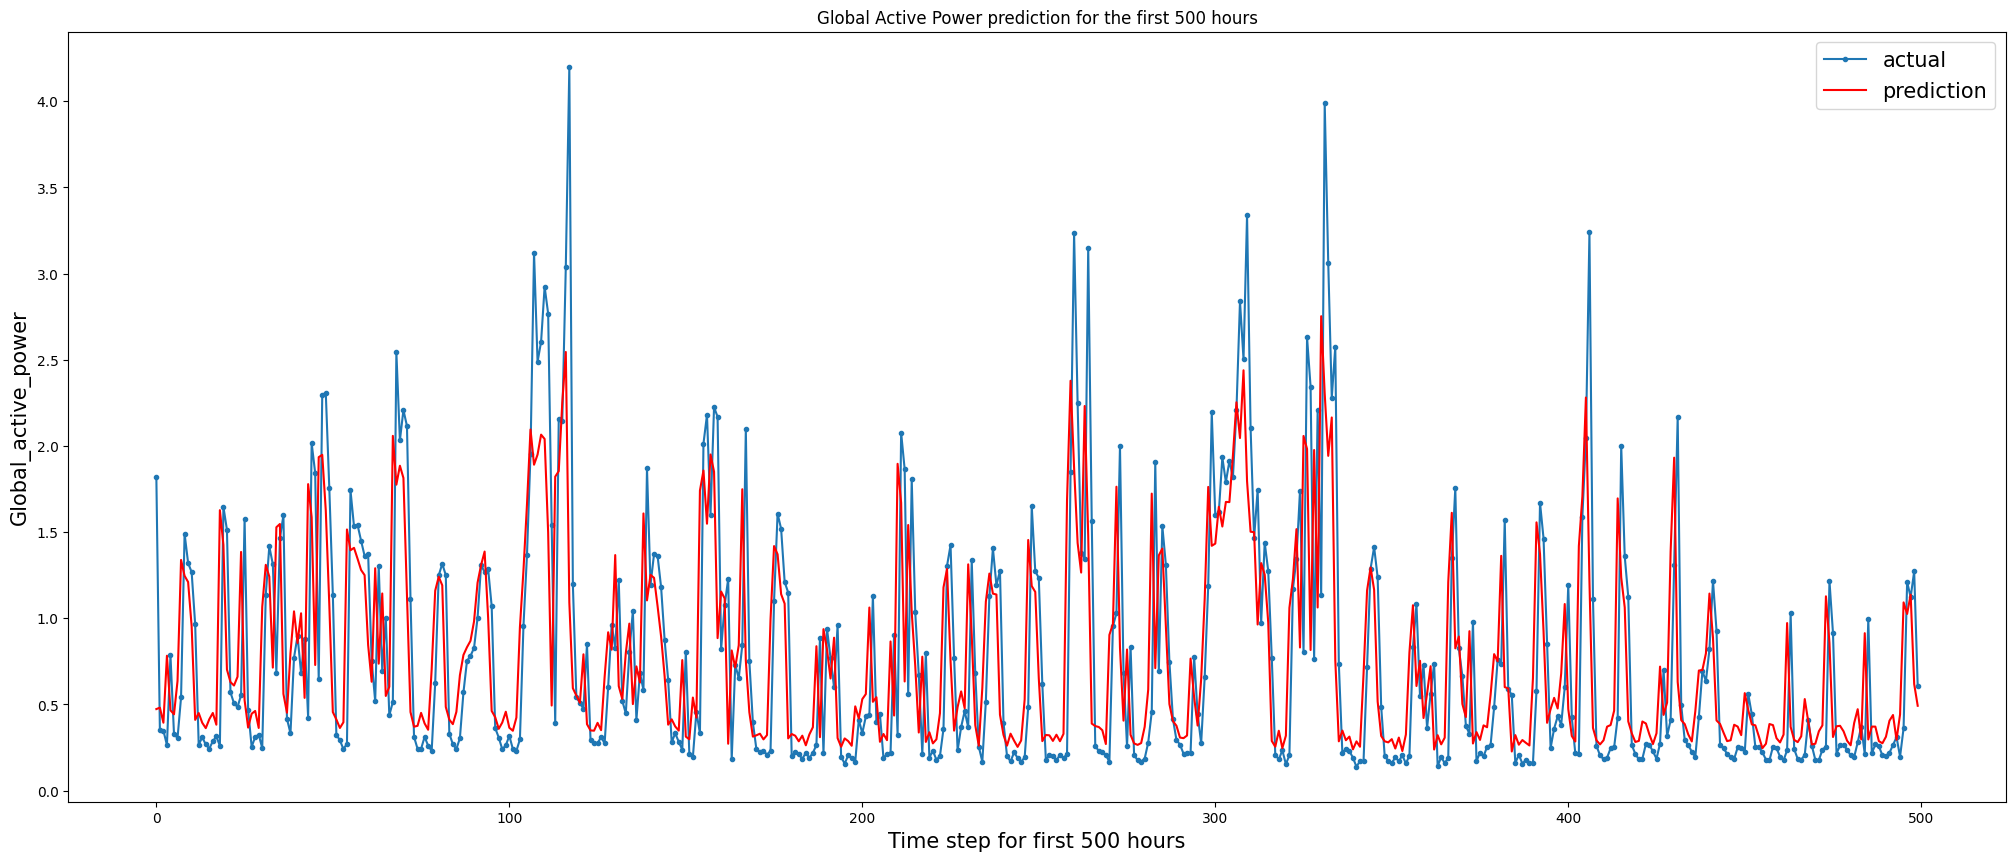

In [ ]:
# Plotting Global Active Power for the first 500 hours.

aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.title('Global Active Power prediction for the first 500 hours')
plt.legend(fontsize=15)
plt.show()

In [ ]:
# Repeating the same example but this time, I am not considering "Voltage"
df3 = df2[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
df3 = df3.drop(['Voltage'],axis=1)

In [ ]:
# Resampling in hours time and checking the shape.
df_resample = d3.resample('h').mean()
df_resample.shape


(34589, 7)

In [ ]:
# Splitting the data into: train and validation sets. Selecting  4000 data over 34,589 dat to train, the rest will be used to test the model.

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

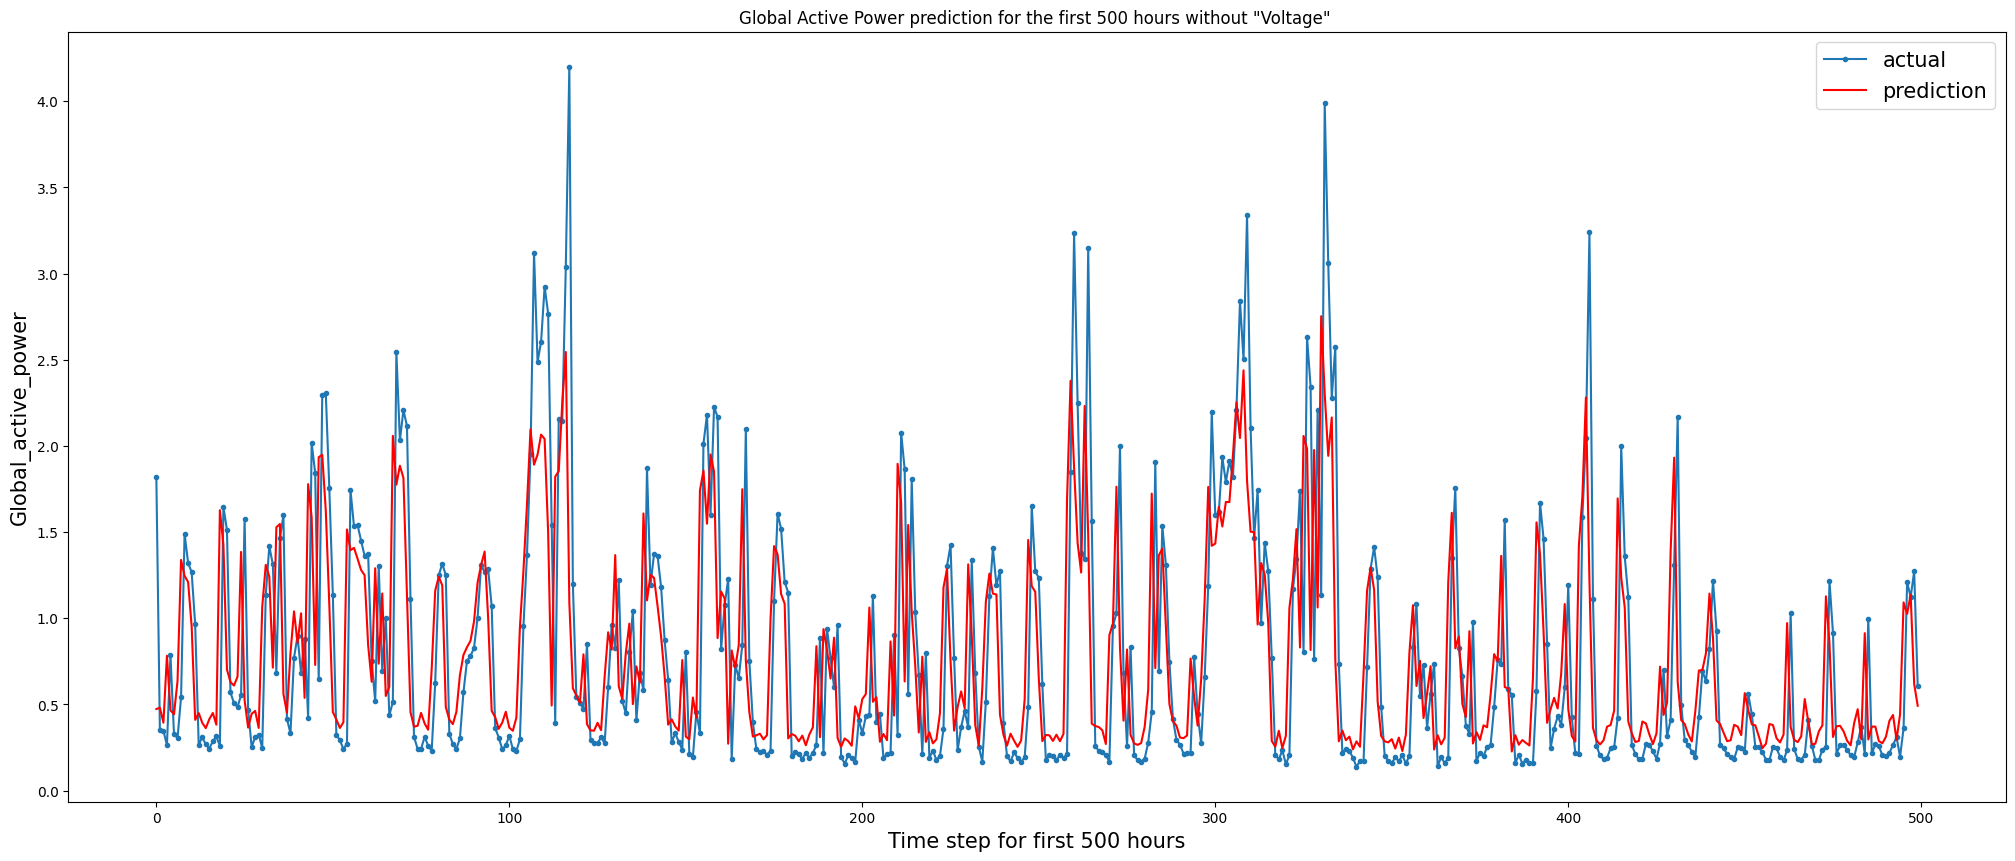

In [ ]:
# Plotting Global Active Power for the first 500 hours without "Voltage".
aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.title('Global Active Power prediction for the first 500 hours without "Voltage" ')
plt.legend(fontsize=15)
plt.show()

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:   

- For this approach, I considered using the time step in hours to save processing time and because, in the previous assignment with Linear Regression, it performed well in predicting the Global Active Power (GAP) output variable. I included all the variables for this LSTM model, leveraging its ability to handle sequences. The results were significantly better than those obtained with linear regression.

- To further optimize, I might experiment with dropping certain variables, such as Global Reactive Power, which, as seen in the previous assignment, showed correlation with Global Active Power but may not provide additional information. Additionally, exploring the same experiment at a minute-level granularity could reveal more detailed insights in the data. Monthly predictions might capture seasonal patterns, offering another avenue for improvement.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:  
-  In comparison to linear regression, the LSTM models provide enhanced capabilities, especially when dealing with non-linear and time-dependent data. Linear regression is constrained by assuming linear behavior, making it less suitable for datasets with complex temporal dependencies. On the other hand, LSTM can handle sequences of varying lengths and focus on relevant parts of the input sequence, adding robustness.

- Considering IoT device considerations, where real-time predictions with a short predictive horizon are crucial, the LSTM model with a 5-minute time step would be more suitable. The LSTM's ability to capture temporal patterns and work with sequences makes it advantageous for forecasting in scenarios where quick and accurate predictions are essential. The flexibility of LSTM in handling time series data aligns well with the dynamic and changing nature of IoT environments.